<a href="https://colab.research.google.com/github/MichalBalcerak/ML24-25/blob/main/Homework03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

My data comes from [https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database/data](https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database/data).\
According to the information provided on Kaggle, 'the objective of the dataset is to diagnostically **predict** whether or not a patient has **diabetes**, based on certain diagnostic measurements included in the dataset.' All patients were females of Pima Indian heritage, aged at least 21 years.

In [16]:
url = "https://raw.githubusercontent.com/MichalBalcerak/ML24-25/refs/heads/main/diabetes.csv"
df = pd.read_csv(url)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [17]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Some records contain a value of 0 in the 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', and 'BMI' columns, which is not acceptable for further analysis. Instead of imputing the missing data using the median, mean, or other methods, I decided to select only rows with non-zero values, as there are still 392 rows remaining for analysis.

In [18]:
df = df[(df["Glucose"] != 0) & (df["BloodPressure"] != 0) &
         (df["SkinThickness"] != 0) & (df["Insulin"] != 0) &
         (df["BMI"] != 0)]

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392 entries, 3 to 765
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               392 non-null    int64  
 1   Glucose                   392 non-null    int64  
 2   BloodPressure             392 non-null    int64  
 3   SkinThickness             392 non-null    int64  
 4   Insulin                   392 non-null    int64  
 5   BMI                       392 non-null    float64
 6   DiabetesPedigreeFunction  392 non-null    float64
 7   Age                       392 non-null    int64  
 8   Outcome                   392 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 30.6 KB


In [19]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

I scale the dataset and divide it into three parts: **train**, **validate** and **test**.\
Then I create logistic regression model and train it on the *train set*.

In [20]:
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

LogisticRegression()

I use the *validation set* to determine the optimal threshold.

Firsty, I use the model to predict probability of membership to class 1 (diabetes). Then I use *roc_curve()* function to get:

*   **FPR** - False positive rate - determined as the ratio of false positives to the total number of true class '0' instances
*   **TPR** - True positive rate - determined as the ratio of true positives to the total number of true class '1' instances

which are calculated for different values of **threshold** - value of probability which is sufficient to classify an observation as class '1' belonging.

TPR is called *sensitivity*.\
FPR is closely related to *specificity* (which is true negatives to the total number of true class '0' instances) as $FPR = 1-specificity$

TPR/FPR ratio for different thresholds is the basis of the **ROC** (Receiver Operating Characteristic) curve. Points in the top-left corner of the plot are desirable, as they indicate high TPR and a low FPR for the given threshold.


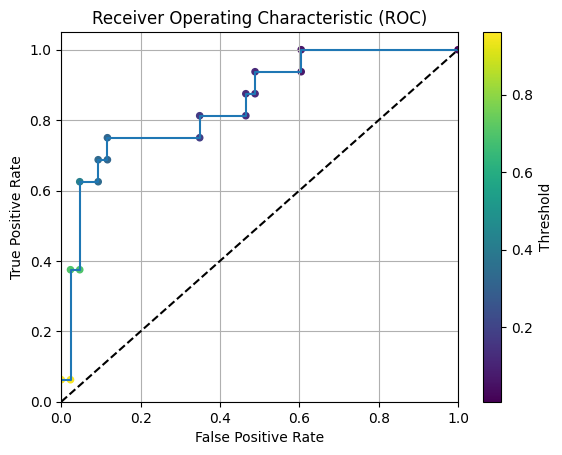

In [21]:
y_val_proba = logistic_model.predict_proba(X_val)[:,-1]
fpr, tpr, thresholds =roc_curve(y_val, y_val_proba)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.scatter(fpr, tpr, c=thresholds, cmap='viridis', s=20, label='Thresholds')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.grid()
plt.colorbar(label='Threshold')
plt.show()

The ROC curve is clearly above identity line, indicating good classifier performance.

An important metric of the ROC curve is **AUC** (area under curve) which can be calculate using the *auc()* function. The higher AUC value (AUC $\in [0,1]$) indicates better-performing classification model. In this case, AUC > 0.8 which is a quite good result.

In [22]:
roc_auc = auc(fpr, tpr)
print(roc_auc)

0.8488372093023256


To determine the optimal threshold we can use **Youden's J statistic** which is defined by $$J = TPR-FPR$$
and is calculated for different thresholds.

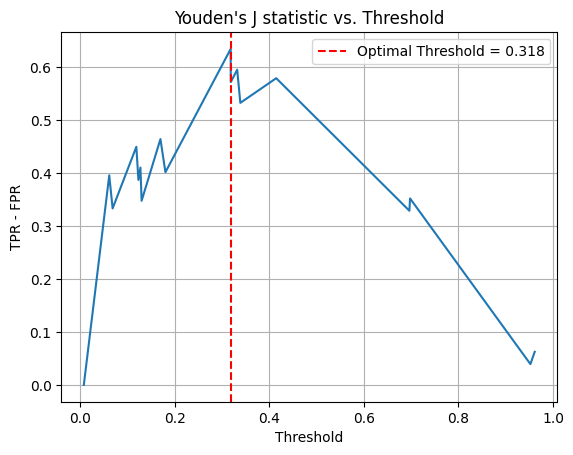

In [23]:
j_scores = tpr - fpr

optimal_idx = np.argmax(j_scores)
optimal_threshold = thresholds[optimal_idx]
optimal_fpr = fpr[optimal_idx]
optimal_tpr = tpr[optimal_idx]

plt.plot(thresholds, j_scores)
plt.axvline(x=optimal_threshold, color='red', linestyle='--', label=f'Optimal Threshold = {optimal_threshold:.3f}')
plt.xlabel("Threshold")
plt.ylabel("TPR - FPR")
plt.title("Youden's J statistic vs. Threshold")
plt.legend()
plt.grid()
plt.show()

Now I apply selected threshold to the *test set*

In [24]:
y_test_proba = logistic_model.predict_proba(X_test)[:,-1]
y_test_pred = (y_test_proba >= optimal_threshold).astype(int)

To evaluate final model performance I use **confusion matrix** which is defined as: $$\begin{bmatrix}
TN & FP \\
FN & TP
\end{bmatrix}
$$
where


*   **TN** - true negatives (number of correctly classified as class '0')
*   **FP** - false positives (number of mistakenly classified as class '1')
*   **FN** - false negatives (number of mistakenly classified as class '0')
*   **TP** - true positives (number of correctly classified as class '1')

I calculate following like:


*   **Accuracy** - $= \frac{TP+TN}{TP+FP+TN+FN}$
*   **Precision** $= \frac{TP}{TP+FP}$
*   **Recall (sensitivity)** $= \frac{TP}{TP+FN}$
*   **Specificity** $= \frac{TN}{TN+FP}$
*   **F1-Score** - harmonic mean of *recall and precision* $=\frac{2}{recall^{-1}+precision^{-1}}=\frac{2TP}{2TP+FP+FN}$





In [25]:
cm = confusion_matrix(y_test, y_test_pred)
tn, fp, fn, tp = cm.ravel()

accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
specificity = tn/(tn+fp)
f1 = f1_score(y_test, y_test_pred)

print(f'''
        Accuracy: {accuracy}\n
        Precision: {precision}\n
        Recall: {recall}\n
        Specificity: {specificity}\n
        F1-Score: {f1}''')


        Accuracy: 0.6610169491525424

        Precision: 0.5384615384615384

        Recall: 0.6363636363636364

        Specificity: 0.6756756756756757

        F1-Score: 0.5833333333333334


# 1. Would a different threshold yield better results?

Yes, as we can see above, using a different threshold instead of standard 0.5 yields a higher TPR/FPR ratio or greater TPR-FPR value.

# 2. How do you define "better" results?

It is always not clear whether the optimal threshold calculated using the Youden's J statistic is the best choice. For example, in medical diagnosis - as in my dataset - it may be more important for the classifier  to have higher sensitivity, since we want to avoid missing potential cases of disease. On the other hand, in scenarios like spam filtering, lower sensitivity might be acceptable as long as specificity remains high, so that important messages are not mistakenly deleted.

# 3. How does a ROC curve help in this process?

The ROC curve can assist in the process of choosing an appropriate threshold. As explained above, the farther a point lies above the identity line, the better the classifier's performance. The ROC curve helps visualize the TPR and FPR for different threshold values, which can be useful in determining the most suitable threshold for a specific case.

# 4. How do you select the optimal threshold using the ROC curve?

In my analysis, I used Youden's J statistic. However, there are other strategies depedning on which type of error is more important to avoid — false positives (e.g., in spam filters) or false negatives (e.g., in disease detection).\
Sometimes, the threshold can be selected based on the distance from the (0,1) point on the ROC curve, which aligns with the earlier observation that points near the top-left corner tend to have a better balance between the true positive rate and the false positive rate.

# 5. What is the AUC metric and how is it useful?

**AUC** (Area Under the Curve) metric is, as mentioned above, measure of a classifier performance. It can takes values from 0 to 1, with a higher value indicating better model quality. A perfect model that classifies the data without any errors has an AUC of 1, while a random model has an AUC of $\frac{1}{2}$. AUC can be interpreted as the probability that, for a randomly chosen pair of examples—one from class 0 and the other from class 1—the model will assign a higher probability to the one from class 1.

Below is the ROC curve with optimal threshold (the point with the highest Youden's J statistic)
marked. As we can see, this selection indicates a high true positive rate (high sensitivity) along high a relatively low false positive rate (relatively high specificity).

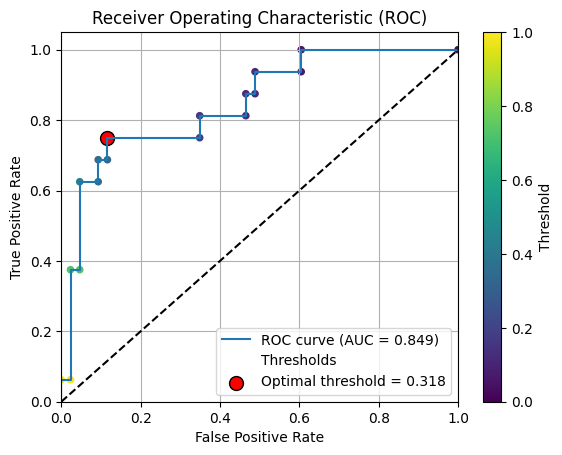

In [26]:
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.scatter(fpr, tpr, c=thresholds, cmap='viridis', s=20, label='Thresholds')
plt.scatter(optimal_fpr, optimal_tpr, color='red', s=100, edgecolors='black',
            label=f'Optimal threshold = {optimal_threshold:.3f}')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend()
plt.grid()
plt.colorbar(label='Threshold')
plt.show()